<b>Importing Relevant Modules</b>

In [1]:
#Importing relevant modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import itertools
import random
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from scipy.ndimage.measurements import label
import time 
%matplotlib inline

<b>Importing Vehicle & Non-Vehicle Images </b>

In [2]:
#Importing vehicle images
GTI_far = glob.glob('vehicles\\GTI_Far\*.png')
GTI_left = glob.glob('vehicles\\GTI_Left\*.png')
GTI_middleclose = glob.glob('vehicles\\GTI_MiddleClose\*.png')
GTI_right = glob.glob('vehicles\\GTI_Right\*.png')
KITTI_extracted = glob.glob('vehicles\\KITTI_extracted\*.png')
car_list = [GTI_far, GTI_left, GTI_middleclose, GTI_right, KITTI_extracted]
car_files = list(itertools.chain.from_iterable(car_list))

#Importing non-vehicle images
GTI_non_vehicle = glob.glob('non-vehicles\\GTI\*.png')
extra_non_vehicle = glob.glob('non-vehicles\\Extras\*.png')
non_carlist = [GTI_non_vehicle, extra_non_vehicle]
non_carfiles = list(itertools.chain.from_iterable(non_carlist))

<b> Functions to Randomly Modify Images </b>

In [3]:
#Randomly modifies image
def modify_image(image, brighten=False, color_change=False):
    '''Change brightness, change color, don't change '''
    
    mod_image = np.copy(image)
    
    #Brighten image
    if brighten==True:
        if np.random.uniform() <= 0.7:
            mod_image = cv2.cvtColor(mod_image, cv2.COLOR_BGR2HSV)
            random_bright = np.random.uniform(low=0.2, high=0.9)
            mod_image[:,:,2] = mod_image[:,:,2] * random_bright
            mod_image = cv2.cvtColor(mod_image, cv2.COLOR_HSV2BGR)
        
    #Change color of image
    if color_change==True:
        if np.random.uniform() <= 0.3:
            rand = np.random.uniform(low=0.2, high=1, size=3)
            mod_image[:,:,0] = mod_image[:,:,0] * rand[0]
            mod_image[:,:,1] = mod_image[:,:,1] * rand[1]
            mod_image[:,:,2] = mod_image[:,:,2] * rand[2]
    
    return mod_image

<b> Functions for Extracting Features, Normalizing Data & Splitting Data </b>

In [4]:
#Finds spatial features through spatial binning of colors
def binspatial(img, size, vis=False):
    '''Returns spatially bin features'''
    if vis == True:
        binspatial_features = cv2.resize(img, size)
    else:
        binspatial_features = cv2.resize(img, size).ravel()
    return binspatial_features

#Finds color histogram features
def color_hist(img , nbins, bins_range=(0,256), plot=False):
    '''Returns color histogram features or plots color histogram is flag set to True'''
    channel_1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel_2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel_3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    if plot == True:
        bin_edges = channel_1[1]
        bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
        
        fig = plt.figure(figsize=(15,3))
        plt.subplot(131)
        plt.bar(bin_centers, channel_1[0])
        plt.xlim(0, 256)
        plt.title('Color Channel 1')
        plt.subplot(132)
        plt.bar(bin_centers, channel_2[0])
        plt.xlim(0, 256)
        plt.title('Color Channel 2')
        plt.subplot(133)
        plt.bar(bin_centers, channel_3[0])
        plt.xlim(0, 256)
        plt.title('Color Channel 3')
        
    elif plot == False:
        chist_features = np.concatenate((channel_1[0], channel_2[0], channel_3[0]))
        return chist_features
    

#Finds histogram of gradient features
def get_hog_features(img, orients, pixels_per_cell, cells_per_block, vis = False, feature_vec = True):
    '''Returns HOG features and/or HOG image'''
    if vis == True:
        features, hog_image = hog(img, orientations=orients, pixels_per_cell = pixels_per_cell,
                                  cells_per_block=cells_per_block, visualise=vis, 
                                  transform_sqrt=False, feature_vector=False)
        return features, hog_image 
    elif vis == False:
        features = hog(img, orientations=orients, pixels_per_cell=pixels_per_cell, 
                       cells_per_block=cells_per_block, visualise=vis, 
                       transform_sqrt=False, feature_vector=True)
    return features

#Extract features of image from list of images
def extract_features(imgs, color_space,
                spatial_feat, spatial_size, hist_feat, color_bins,
                hog_feat, orients,pixels_per_cell, cells_per_block,hog_channel, 
                brighten=True, color_change=True):
    
    '''Extracts features from a list of images'''
    #List to append feature vector
    features = []
    
    #Iterate through list of images
    for file in imgs:
        file_features = []
        
        #Reads image
        image = cv2.imread(file)
        
        #Modifies color and brightness of image
        image = modify_image(image, brighten=brighten, color_change=color_change)
        
        #Changes color space if applicable
        if color_space.upper() != 'BGR':
            string = 'cv2.COLOR_BGR2' + color_space
            feature_image = cv2.cvtColor(image, eval(string))
        else:
            feature_image = np.copy(image)
            
        #Computes spatial features
        if spatial_feat == True:
            spatial_features = binspatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        #Computes color histogram
        if hist_feat == True:
            color_histogram = color_hist(feature_image, nbins=color_bins)
            file_features.append(color_histogram)
            
        #Computes HOG
        if hog_feat==True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_feature = get_hog_features(feature_image[:,:,channel], orients, 
                                                   pixels_per_cell, cells_per_block)
                    hog_features.append(hog_feature)
                    
                hog_features = np.ravel(hog_features)
            else: 
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orients, pixels_per_cell, cells_per_block)
            file_features.append(hog_features)
        
        #Appends file_features to features
        features.append(np.concatenate(file_features))
        
    return features
                
#Normalize extracted features and also returns feature labels
def normalize_features(car_features, noncar_features):
    '''Normalizes extracted image features and also returns feature labels'''
    features = np.vstack([car_features, noncar_features]).astype(np.float64)
    feature_scaler = StandardScaler().fit(features)
    scaled_features = feature_scaler.transform(features)
    
    labels = np.hstack((np.ones(len(car_features)),np.zeros(len(noncar_features))))
    
    return feature_scaler, scaled_features, labels

#Splitting and shuffling data 
def split_data(scaled_features, labels, train_size=0.6):
    '''Splits data using sklearn.model_selection.test_train_split'''
    rand_state = np.random.randint(0,100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels, train_size= train_size, 
                                                        random_state=rand_state)
    
    return X_train, X_test, y_train, y_test


<b> Functions for Sliding Windows Search </b>

In [5]:
#Draw Box
def draw_boxes(image, bboxes, color=[0,0,255], thick=6):
    '''Draws bounding box on image'''
    img_copy = np.copy(image)
    
    for bbox in bboxes:
        cv2.rectangle(img_copy, bbox[0], bbox[1], color, thick)
    
    return img_copy

#Sliding window
def slide_window(image, x_start_stop=[None,None], y_start_stop=[None,None],
                xy_window=(64,64), xy_overlap=(0.5,0.5)):
    '''Sliding window to find list of bounding window'''
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = image.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = image.shape[0]
        
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0] * (1-xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[0] * (1-xy_overlap[1]))
    nx_buffer = np.int(xy_window[0] * xy_overlap[0])
    ny_buffer = np.int(xy_window[1] * xy_overlap[1])
    
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty),(endx, endy)))
    
    return window_list

#Extract features from single image
def single_img_features(image, color_space,
                spatial_feat, spatial_size, hist_feat, color_bins,
                hog_feat, orients,pixels_per_cell, cells_per_block, hog_channel):
    
    '''Extract features from a single image'''
    img_features = []
    
    if color_space != 'BGR':
        string = 'cv2.COLOR_BGR2' + color_space
        feature_image = cv2.cvtColor(image, eval(string))
    else:
        feature_image = np.copy(image)
    
    if spatial_feat == True:
        spatial_features = binspatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    
    if hist_feat == True:
        color_histogram = color_hist(feature_image, nbins=color_bins)
        img_features.append(color_histogram)
        
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_feature = get_hog_features(feature_image[:,:,channel], orients, 
                                               pixels_per_cell, cells_per_block)
                
                hog_features.append(hog_feature)
                
            hog_features = np.ravel(hog_features)
        else:
            hog_feature = get_hog_features(feature_image[:,:,channel], orients, 
                                           pixels_per_cell, cells_per_block)
        img_features.append(hog_features)
    
    features = np.concatenate(img_features)
    
    return features

#Search window 
def search_windows(image, windows,clf, scaler, color_space, 
            spatial_feat, spatial_size, hist_feat, color_bins, 
            hog_feat, orients, pixels_per_cell, cells_per_block, hog_channel): 
    
    on_windows = []
    
    for window in windows:
        test_img = cv2.resize(image[window[0][1]:window[1][1],window[0][0]:window[1][0]], (64,64))
    
        features = single_img_features(test_img, color_space=color_space, 
                                spatial_feat=spatial_feat, spatial_size=spatial_size,
                                hist_feat=hist_feat, color_bins=color_bins,
                                hog_feat=hog_feat, orients=orients, pixels_per_cell=pixels_per_cell, 
                                cells_per_block=cells_per_block, hog_channel=hog_channel)
    
        test_features = scaler.transform(np.array(features).reshape(1, -1))
            
        prediction = clf.predict(test_features)  
    
        if prediction == 1:
            on_windows.append(window)
    
    return on_windows

<b> Functions for Heatmaps </b>

In [6]:
def add_heat(heatmap, bbox_list):
    '''Creates a heatmap from bounding box list'''
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    return heatmap

def apply_threshold(heatmap, threshold):
    '''Sets pixels below certain threshold to zero'''
    heatmap[heatmap < threshold] = 0
    
    return heatmap

def draw_labeled_boxes(img, labels):
    '''Draws labeled boxes'''
    for car_number in range(1, labels[1]+1):
        #Finds non-zero pixels
        non_zero = (labels[0] == car_number).nonzero()
        non_zero_y = np.array(non_zero[0])
        non_zero_x = np.array(non_zero[1])
        
        #Set start and end point for rectangle
        bbox = ((np.min(non_zero_x), np.min(non_zero_y)), (np.max(non_zero_x), np.max(non_zero_y)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img


<b> Visualizing Training Images</b>

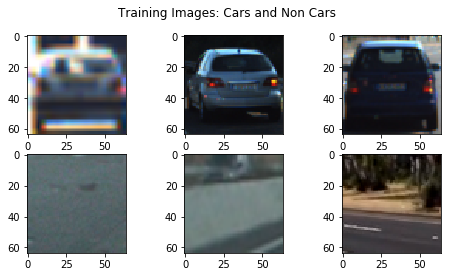

In [7]:
#Get random cars and non cars sample from data set
cars = random.sample(car_files, 3)
non_cars = random.sample(non_carfiles,3)

car_bgr = []
car_rgb = []
non_car_bgr = []
non_car_rgb = []

for car in cars:
    img = cv2.imread(car)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    car_bgr.append(img)
    car_rgb.append(img_rgb)

for non_car in non_cars:
    img = cv2.imread(non_car)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    non_car_bgr.append(img)
    non_car_rgb.append(img_rgb)
    
fig = plt.figure(figsize=(8,4))
plt.subplot(231)
plt.imshow(car_rgb[0])
plt.subplot(232)
plt.imshow(car_rgb[1])
plt.subplot(233)
plt.imshow(car_rgb[2])
plt.subplot(234)
plt.imshow(non_car_rgb[0])
plt.subplot(235)
plt.imshow(non_car_rgb[1])
plt.subplot(236)
plt.imshow(non_car_rgb[2])
plt.suptitle('Training Images: Cars and Non Cars')

<b> Visualizing Features to be Extracted </b>

C:\Users\Michelle\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


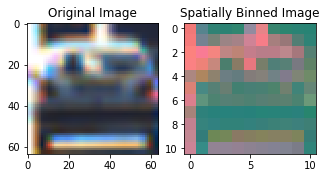

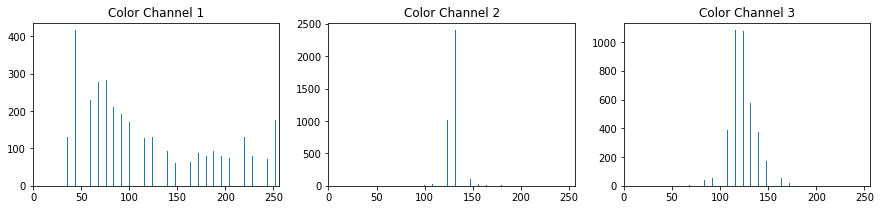

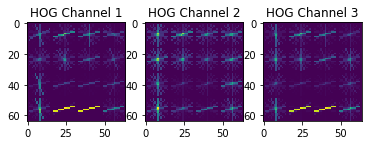

In [8]:
lab_image = cv2.cvtColor(np.copy(car_rgb[0]), cv2.COLOR_RGB2Lab)

#Visualize Spatial Binning of Colors features
bin_spatial_image = binspatial(lab_image, size=(11,11), vis=True)
fig = plt.figure(figsize=(8,6))

plt.subplot(131)
plt.imshow(car_rgb[0])
plt.title('Original Image')
plt.subplot(132)
plt.imshow(bin_spatial_image)
plt.title('Spatially Binned Image')

#Visualize Color Histogram features
color_hist(lab_image, nbins=32, bins_range=(0,256), plot=True)

#Visualize HOG Features
c1_feat, c1_img = get_hog_features(img=lab_image[:,:,0], orients=9, pixels_per_cell=(16,16), 
                                   cells_per_block=(2,2), vis = True, feature_vec = True)
c2_feat, c2_img = get_hog_features(img=lab_image[:,:,1], orients=9, pixels_per_cell=(16,16), 
                                   cells_per_block=(2,2), vis = True, feature_vec = True)
c3_feat, c3_img = get_hog_features(img=lab_image[:,:,2], orients=9, pixels_per_cell=(16,16), 
                                   cells_per_block=(2,2), vis = True, feature_vec = True)

fig = plt.figure(figsize=(6,6))

plt.subplot(131)
plt.imshow(c1_img)
plt.title('HOG Channel 1')
plt.subplot(132)
plt.imshow(c2_img)
plt.title('HOG Channel 2')
plt.subplot(133)
plt.imshow(c3_img)
plt.title('HOG Channel 3')

<b> Training Classifier and Predicting Accuracy </b>

In [9]:
color_space = 'Lab'
spatial_feat = True
spatial_size = (11,11)
hist_feat=True 
color_bins=32
hog_feat=True
orients=9
pixels_per_cell=(16,16)
cells_per_block=(2,2) 
hog_channel='ALL'


t=time.time()

car_features = extract_features(car_files, color_space=color_space,
                        spatial_feat=spatial_feat, spatial_size=spatial_size,
                        hist_feat=hist_feat, color_bins=color_bins,
                        hog_feat=hog_feat, orients=orients,
                        pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
                        hog_channel=hog_channel, brighten=False, color_change=False)



non_carfeatures = extract_features(non_carfiles,color_space=color_space,
                            spatial_feat=spatial_feat, spatial_size=spatial_size,
                            hist_feat=hist_feat, color_bins=color_bins,
                            hog_feat=hog_feat, orients=orients,
                            pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
                            hog_channel=hog_channel, brighten=False, color_change=False)



feature_scaler, scaled_features, labels = normalize_features(car_features, non_carfeatures)


X_train, X_test, y_train, y_test = split_data(scaled_features, labels)
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

clf.predict(X_test)
print('Prediction Accuracy:', clf.score(X_test, y_test))
t2 = time.time()
training_time = round(t2-t, 4)
print(training_time, 'Seconds to train SVC...')

C:\Users\Michelle\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Prediction Accuracy: 0.991690140845
80.6826 Seconds to train SVC...


<b> Detecting Vehicles in Single Image <b>

C:\Users\Michelle\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


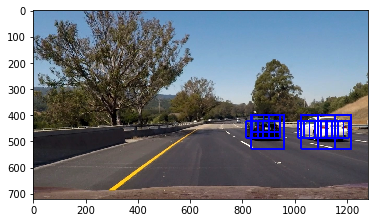

In [10]:
picture = cv2.imread('test_images\\test6.jpg')


draw_image = cv2.cvtColor(np.copy(picture), cv2.COLOR_BGR2RGB)

window_cases = []

window_case_1 = [(64,64), (0.65,0.65), (400,500)]
window_case_2 = [(128,128), (0.5,0.5), (400,600)]
window_case_3 = [(256,256),(0.5,0.5),(400,720)]

window_cases = [window_case_1, window_case_2, window_case_3]

windows = []
for window_case in window_cases:
    y_start_stop = window_case[2] 
    xy_window = window_case[0]
    xy_overlap = window_case[1]

    windows_iter = slide_window(picture, x_start_stop=[None,None], y_start_stop=y_start_stop,
                            xy_window=xy_window, xy_overlap=xy_overlap)
    windows.append(windows_iter)

windows = list(itertools.chain.from_iterable(windows))

hot_windows = search_windows(picture, windows, clf, scaler=feature_scaler, color_space=color_space, 
                        spatial_feat=spatial_feat, spatial_size=spatial_size, 
                        hist_feat=hist_feat, color_bins=color_bins, hog_feat=hog_feat, 
                        orients=orients, pixels_per_cell=pixels_per_cell,
                        cells_per_block=cells_per_block, hog_channel=hog_channel)
                             
                                        
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

<b> Heat Map to Consolidate Boxes and Remove False Positives </b>

2


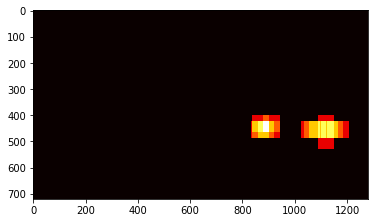

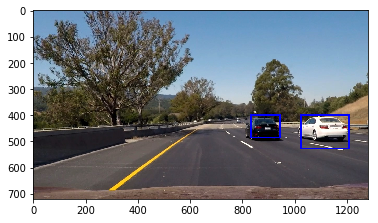

In [11]:
heatmap = np.zeros_like(picture[:,:,0])

heatmap = add_heat(heatmap, hot_windows)

heatmap = apply_threshold(heatmap, 2)

plt.imshow(heatmap, cmap='hot')

labels = label(heatmap)
print(labels[1])

plt.figure()
img = np.copy(picture)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
final_image = (draw_labeled_boxes(img,labels))

plt.imshow(final_image)

<b> Detecting vehicles from Videos </b>

In [12]:
class ProcessVideo():
    
    def __init__(self, scaler, feature_scaler):
        self.scaler = clf
        self.feature_scaler = feature_scaler
        
    def process_vid(self, frame):
        #Defining parameters to be similar to those use for training
        color_space = 'Lab'
        spatial_feat = True
        spatial_size = (11,11)
        hist_feat=True 
        color_bins=32
        hog_feat=True
        orients=9
        pixels_per_cell=(16,16)
        cells_per_block=(2,2) 
        hog_channel='ALL'
        
        #Creates copy of frame to draw on
        draw_image = np.copy(frame)
        
        #Converts frame color space
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        #Defines different sizes of windows
        window_cases = []

        window_case_1 = [(64,64), (0.65,0.65), (400,500)]
        window_case_2 = [(128,128), (0.5,0.5), (400,600)]
        window_case_3 = [(256,256),(0.5,0.5),(400,720)]

        window_cases = [window_case_1, window_case_2, window_case_3]

        windows = []
        
        #Finds windows
        for window_case in window_cases:
            y_start_stop = window_case[2] 
            xy_window = window_case[0]
            xy_overlap = window_case[1]

            windows_iter = slide_window(frame, x_start_stop=[None,None], y_start_stop=y_start_stop,
                                    xy_window=xy_window, xy_overlap=xy_overlap)
            
            windows.append(windows_iter)
            
        windows = list(itertools.chain.from_iterable(windows))
            
        #Search windows for cars
        hot_windows = search_windows(frame, windows, self.scaler, scaler=self.feature_scaler, color_space=color_space, 
                                spatial_feat=spatial_feat, spatial_size=spatial_size, 
                                hist_feat=hist_feat, color_bins=color_bins, hog_feat=hog_feat, 
                                orients=orients, pixels_per_cell=pixels_per_cell,
                                cells_per_block=cells_per_block, hog_channel=hog_channel)
        
        #Heat map to consolidate boxes and remove false positives
        heatmap = np.zeros_like(frame[:,:,0])

        heatmap = add_heat(heatmap, hot_windows)

        heatmap = apply_threshold(heatmap, 2)
        
        labels = label(heatmap)
        
        drawn = draw_labeled_boxes(draw_image,labels)
        
        return drawn 
        

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

processvideo = ProcessVideo(clf, feature_scaler)

detection_output = 'test.mp4'
clip1 = VideoFileClip("project_video.mp4")
detection_clip = clip1.fl_image(processvideo.process_vid) 
%time detection_clip.write_videofile(detection_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(detection_output))

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [12:58<00:00,  1.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

Wall time: 12min 59s
